In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tkinter import Tk     


# Data selection
choose which data are used in the experiment, english and thai one

In [25]:
# read and claen the data file from task III (image word relationship test)
# let the user choose the file
 
from tkinter.filedialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing

username = input("user identity (this string will be named in front of every graph picture):")
datafile = askopenfilename(title="Choose the data file from the experiment, TH mode")
imgordth = pd.read_csv(datafile)
datafile = askopenfilename(title="Choose the data file from the experiment, EN mode")
imgorden = pd.read_csv(datafile)


# cleaning data
this but a simple row removal and column renaming for convenience

In [28]:
# claenadata
def III_cut_and_clean(prepdf):
    cutdf = prepdf.iloc[1:241][["lang","wordid","truestate","image.started","key_resp.started","key_resp.keys","key_resp.rt"]].reset_index(drop=True)
    cutdf = cutdf.rename({"image.started":"word_show","key_resp.started":"image_show","key_resp.keys":"key","key_resp.rt":"key_RT"}, axis="columns")
    return cutdf

imgordth = III_cut_and_clean(imgordth)
imgorden = III_cut_and_clean(imgorden)

# call the reference table
oldword = pd.read_excel("./image test/ref/wordlist_dict.xlsx")
newword = pd.read_excel("./image test/ref/newwordlist_dict.xlsx")


# Define function that add that word is shown and whether if its an old or new image
add column `word shown` for easier datafram reading, `old-new` for a new and old word, and `len` for word length

In [29]:
# add word that actually show and add is it an old or new word
# also add length of that word

# but need to read the file language first
def III_wordload_len_learnt(cutdf):
    if cutdf.iloc[0,0] == 1:
        print("thai language experiemnt loaded")
        globallang = 'th'

    elif cutdf.iloc[0,0] == 2:
        print("english language experiemnt loaded")
        globallang = 'en'

    else:
        print("??????????????????? what file did you choose dawg?")

    for i in range(0,len(cutdf.index)):
        idnow = cutdf.loc[i,"wordid"]
        if idnow in oldword['imgid'].values :
            wordshown = oldword.loc[(oldword['imgid'] == idnow), [globallang]].values[0]
            cutdf.loc[i,"word shown"] = wordshown
            cutdf.loc[i,"old-new"] = "old"

        elif idnow in newword['imgid'].values:
            wordshown = newword.loc[(newword['imgid'] == idnow), [globallang]].values[0]
            cutdf.loc[i,"word shown"] = wordshown
            cutdf.loc[i,"old-new"] = "new"
        else:
            print("unkown id used in the experiment file, stopping loop")
            break

        cutdf.loc[i, "len"] = len(wordshown[0])


In [30]:
III_wordload_len_learnt(imgorden)
III_wordload_len_learnt(imgordth)

english language experiemnt loaded
thai language experiemnt loaded


In [31]:
# special, remove the word that user is not understandf before
def III_remove_excluded_words(df, exclude_words):
    # Ensure 'word shown' is a string column, and then strip and convert to lowercase
    df['word shown'] = df['word shown'].astype(str).str.strip().str.lower()

    # Convert the exclude_words list to lowercase for case-insensitivity
    exclude_words = [word.lower() for word in exclude_words]

    # Filter out rows where 'word shown' contains any of the words in exclude_words
    df_filtered = df[~df['word shown'].isin(exclude_words)]
    
    print(f"Rows removed: {len(df) - len(df_filtered)}")  # Print how many rows were removed
    return df_filtered

In [32]:
exclude_words =  ["pear", "hose", "drill", "couch"]
imgorden = III_remove_excluded_words(imgorden, exclude_words)

Rows removed: 16


# Assign score 

In [39]:
# read the key and truestate file --> assign scoer --> plot total score in each correct and incorrect
def III_total_score(cutdf, titlelang, dir):
    cutdf.loc[(cutdf["truestate"] == 0) & (cutdf["key"] == 'z'),"score"] = 0
    cutdf.loc[(cutdf["truestate"] == 0) & (cutdf["key"] == 'x'),"score"] = 1
    cutdf.loc[(cutdf["truestate"] == 1) & (cutdf["key"] == 'z'),"score"] = 1
    cutdf.loc[(cutdf["truestate"] == 1) & (cutdf["key"] == 'x'),"score"] = 0

    correctscore = cutdf.loc[cutdf['score'] == 1, "score"].count()
    wrongscore = cutdf.loc[cutdf['score'] == 0,"score"].count()
    total = correctscore + wrongscore

    # xlabelstr = f"{100*correctscore / total:.2f}%({correctscore}) correct, {100*wrongscore / total:.2f}%({wrongscore}) wrong, {total} total"
    
    # plt.figure(figsize=(6, 5))
    # plt.bar(["correct", "incorrect"],[correctscore, wrongscore], width=0.5, edgecolor='black')
    # plt.title(f"correct and incorrect ratio, {titlelang}")
    # plt.ylabel("choice frequency")
    # plt.xlabel(xlabelstr)
    # plt.savefig(dir)

III_total_score(imgorden, "english", "./figure/III-ratio EN.png")
III_total_score(imgordth, "thai", "./figure/III-ratio TH.png")

In [40]:
imgordall = pd.concat([imgorden, imgordth], ignore_index=True)

# Coloring variable

In [34]:
redgradient = ["#ffa5bb","#ff9eb6", "#ff7d9d", "#ff6087","#ff0040" ] # thai language, use the last index value as the main color
bluegradient = ["#c0d7ff", "#92bcff", "#5e9eff","#3686ff","#0067ff" ] # english language, use the last index value as the main color
gaygradient = ["#949494", '#727272', '#4b4b4b', '#484848', '#373737'] # overall gradient
colincorrect = '#ff6962'
colcorrect  = '#77dd76'

# plot correct and wrong responses for each word length
self explanatory, plot correct and wrong count from `score` by the column `len`

and also chi square table, tho, its only readable in here, maybe export it too?

In [37]:

from scipy.stats import chi2_contingency

def III_plot_chi_square(df, title="Correct and Incorrect Scores by Word Length", savefig_dir=None):
   # Grouping by 'len' and 'score' to get counts
    count_table = pd.crosstab(df['len'], df['score'], margins=False)

    # Plotting the stacked bar plot with custom colors (red for incorrect, blue for correct)
    ax = count_table.plot(kind='bar', stacked=True, color=[colincorrect, colcorrect], figsize=(8, 6), edgecolor = 'black')

    # Adding labels and title
    plt.xlabel('Word Length')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=0)
    plt.legend(['Incorrect (0)', 'Correct (1)'])

    # Adding labels on top of each bar, positioned on the same axis
    for i in range(len(count_table)):
        bottom_value = 0  # To position the correct label on top of the bars
        for j in range(len(count_table.columns)):
            value = count_table.iloc[i, j]
            if value > 0:
                ax.text(i, bottom_value + value / 2, str(value), ha='center', va='center', fontsize=10, color =  'black')
                bottom_value += value  # Update the bottom_value to stack the next value on top

    # Saving the plot if a save directory is specified
    if savefig_dir:
        plt.savefig(savefig_dir)
        print(f"Plot saved to {savefig_dir}")
    else:
        plt.show()

    # Chi-square test
    chi2, p, dof, expected = chi2_contingency(count_table)

    # Creating a DataFrame to display the chi-square test results
    chi_square_results = pd.DataFrame({
        'Chi-square Statistic': [chi2],
        'P-value': [p],
        'Degrees of Freedom': [dof],
        'Expected Frequencies': [expected]
    })

    # Displaying the chi-square test results as a DataFrame
    print("\nChi-square Test Results:")
    print(chi_square_results)


In [ ]:
III_plot_chi_square(imgordall, "correct/wrong count by word length: overall",f"./figure/{username} III ratio by len all.png")
III_plot_chi_square(imgorden,  "correct/wrong count by word length: english",f"./figure/{username} III ratio by len EN.png")
III_plot_chi_square(imgordth,  "correct/wrong count by word length: thai",   f"./figure/{username} III ratio by len TH.png")

KeyError: 'score'

# plot accuracy response for each word length
self explanatory, plot correct and wrong accuracy from `score` by the column `len`

In [ ]:

def III_plot_correct_accuracy(df, dir, title="Proportion of Correct Responses by Word Length"):
    """
    Plots the proportion of correct responses for each word length as a bar chart.

    Parameters:
        df (pd.DataFrame): DataFrame with 'len' (word length) and 'score' (0 or 1).
        title (str): Title of the plot.
    """
    # Calculate proportions
    proportion_df = df.groupby('len')['score'].mean() * 100  # Convert to percentage

    # Plot
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=proportion_df.index, y=proportion_df.values, palette= gaygradient, edgecolor='black',width=0.5)

    # Add labels on top of bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", 
                    (p.get_x() + p.get_width() / 2, p.get_height() + 2), 
                    ha='center', va='bottom', fontsize=10, fontweight='light', color='black')

    # Formatting
    plt.xlabel("Word Length")
    plt.ylabel("Correct Proportion (%)")
    plt.title(title)
    plt.ylim(0, 100)  # Ensure percentage scale

    plt.savefig(dir)


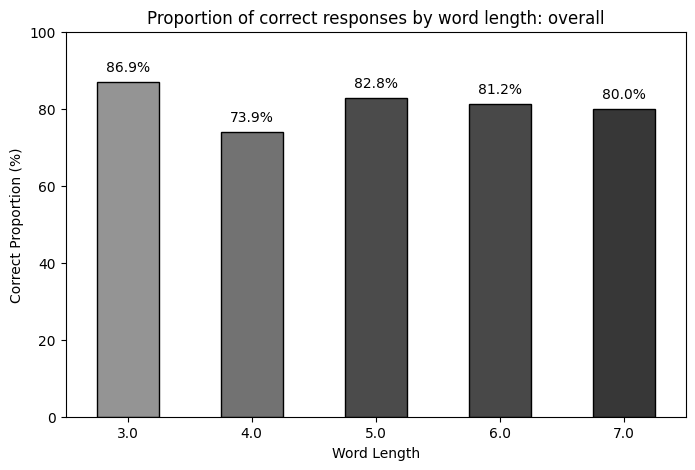

In [220]:
III_plot_correct_accuracy(imgordall,f"./figure/{username} III percent by len all.png", "Proportion of correct responses by word length: overall")

# plot accuracy response for each word length in thai and english language
 plot correct and wrong accuracy both thai and english as percentage from `score` by the column `len`

In [221]:


def III_plot_grouped_proportion(df1, df2, dir, title="Comparison of Correct Proportion by Word Length"):
    """
    Plots the proportion of correct responses for two DataFrames as a grouped bar chart.

    Parameters:
        df1 (pd.DataFrame): First dataset with 'len' and 'score'.
        df2 (pd.DataFrame): Second dataset with 'len' and 'score'.
        labels (tuple): Labels for the two datasets (e.g., ("Dataset 1", "Dataset 2")).
        title (str): Title of the plot.
    """
    # Calculate proportions
    proportion_df1 = df1.groupby('len')['score'].mean() * 100
    proportion_df2 = df2.groupby('len')['score'].mean() * 100

    # Merge into a single DataFrame for plotting
    labels=["thai", "english"]
    prop_df = pd.DataFrame({labels[0]: proportion_df1, labels[1]: proportion_df2}).reset_index()

    # Sample data from prop_df
    len_values = prop_df['len']
    values = [prop_df['thai'], prop_df['english']]
    colors = [bluegradient, redgradient]
    labels = ["Thai", "English"]

    # Bar width and positions
    bar_width = 0.4
    x = np.arange(len(len_values))  # X positions for groups

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 5))

    # Loop through Thai and English data
    for i, (val, color, label) in enumerate(zip(values, colors, labels)):
        bars = ax.bar(x + (i - 0.5) * bar_width, val, width=bar_width, color=color, edgecolor='black', label=label)

        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 5), textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='light')

    # X-axis settings
    ax.set_xticks(x)
    ax.set_xticklabels(len_values.astype(int))
    ax.set_xlabel("Word Length")
    ax.set_ylabel("Proportion of Correct Responses (%)")
    ax.set_title(title)
    ax.set_ylim(0,110)
    # Add legend
    ax.legend(loc = 'upper right')

    # Show plot
    plt.savefig(dir)


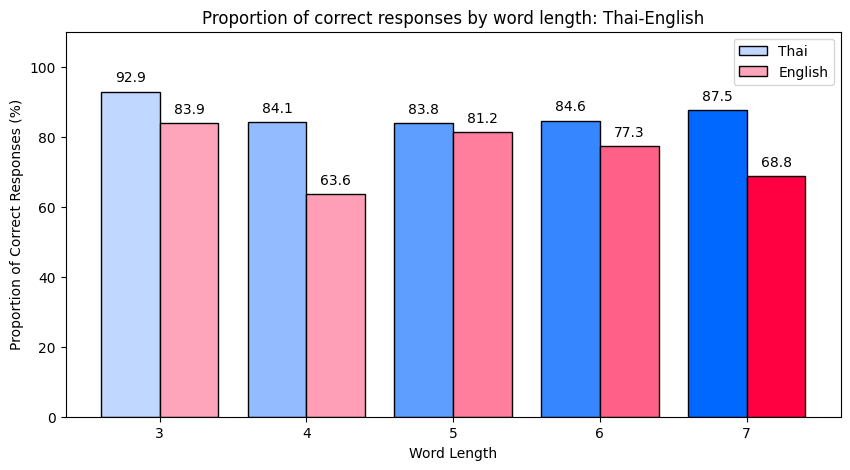

In [222]:
III_plot_grouped_proportion(imgordth,imgorden,f"./figure/{username} III percent by len TH-EN.png","Proportion of correct responses by word length: Thai-English")

# plot image and word accuracy
plot both accuracy of the task order that word shown match the image and word shown is not matched with the image

In [20]:


def III_plot_image_accuracy(df, title="Image Accuracy", save_path=None):
    """
    Plots the correct and incorrect image accuracy as a bar chart.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'truestate' (0 or 1) and 'key' ('z' or 'x') columns.
    title (str): Title of the plot.
    save_path (str, optional): File path to save the figure. If None, the plot is shown instead.
    """
    # Calculate correct image accuracy
    correct_total = df[df['truestate'] == 1].shape[0]
    correct_match = df[(df['truestate'] == 1) & (df['key'] == 'z')].shape[0]
    correct_accuracy = (correct_match / correct_total) * 100 if correct_total else 0

    # Calculate incorrect image accuracy
    incorrect_total = df[df['truestate'] == 0].shape[0]
    incorrect_match = df[(df['truestate'] == 0) & (df['key'] == 'x')].shape[0]
    incorrect_accuracy = (incorrect_match / incorrect_total) * 100 if incorrect_total else 0

    # Bar chart data
    categories = ['Correct Image Accuracy', 'Incorrect Image Accuracy']
    values = [correct_accuracy, incorrect_accuracy]

    # Plot
    plt.figure(figsize=(6, 7))
    bars = plt.bar(categories, values, color=[colcorrect, colincorrect], width=0.5, edgecolor = 'black')
    plt.ylabel('Accuracy (%)')
    plt.title(title)
    plt.ylim(0, 110)

    # Add percentage labels on top of bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{value:.1f}%', 
                 ha='center', fontsize=10, fontweight='light')

    # Save or show plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Plot saved to {save_path}")
    else:
        plt.show()

# Example usage
data = {'truestate': [1, 0, 1, 1, 0, 0, 1, 0, 1, 1],
        'key': ['z', 'x', 'z', 'x', 'x', 'z', 'z', 'x', 'z', 'x']}
df = pd.DataFrame(data)


Plot saved to ./figure/YP III image truefalse All.png


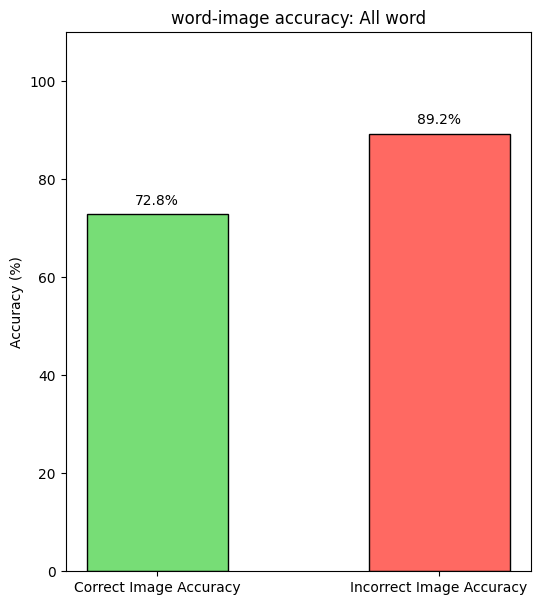

In [21]:
III_plot_image_accuracy(imgordall, "word-image accuracy: All word", f"./figure/{username} III image truefalse All.png")

#  grouped bar chart with the correct and incorrect image accuracy, both language

In [225]:
def III_accuracy_group(df1, df2, title="Image Accuracy", save_path=None):
    """
    Plots a grouped bar chart with the correct and incorrect image accuracy for two dataframes.

    Parameters:
    df1 (pd.DataFrame): First DataFrame containing 'truestate' (0 or 1) and 'key' ('z' or 'x') columns.
    df2 (pd.DataFrame): Second DataFrame containing 'truestate' (0 or 1) and 'key' ('z' or 'x') columns.
    title (str): Title of the plot.
    save_path (str, optional): File path to save the figure. If None, the plot is shown instead.
    """
    # Calculate correct image accuracy for df1
    correct_total_1 = df1[df1['truestate'] == 1].shape[0]
    correct_match_1 = df1[(df1['truestate'] == 1) & (df1['key'] == 'z')].shape[0]
    correct_accuracy_1 = (correct_match_1 / correct_total_1) * 100 if correct_total_1 else 0

    # Calculate incorrect image accuracy for df1
    incorrect_total_1 = df1[df1['truestate'] == 0].shape[0]
    incorrect_match_1 = df1[(df1['truestate'] == 0) & (df1['key'] == 'x')].shape[0]
    incorrect_accuracy_1 = (incorrect_match_1 / incorrect_total_1) * 100 if incorrect_total_1 else 0

    # Calculate correct image accuracy for df2
    correct_total_2 = df2[df2['truestate'] == 1].shape[0]
    correct_match_2 = df2[(df2['truestate'] == 1) & (df2['key'] == 'z')].shape[0]
    correct_accuracy_2 = (correct_match_2 / correct_total_2) * 100 if correct_total_2 else 0

    # Calculate incorrect image accuracy for df2
    incorrect_total_2 = df2[df2['truestate'] == 0].shape[0]
    incorrect_match_2 = df2[(df2['truestate'] == 0) & (df2['key'] == 'x')].shape[0]
    incorrect_accuracy_2 = (incorrect_match_2 / incorrect_total_2) * 100 if incorrect_total_2 else 0

    # Bar chart data
    categories = ['Correct Image Accuracy', 'Incorrect Image Accuracy']
    values_1 = [correct_accuracy_1, incorrect_accuracy_1]
    values_2 = [correct_accuracy_2, incorrect_accuracy_2]

    # Plot
    width = 0.35  # Width of bars
    fig, ax = plt.subplots(figsize=(8, 6))

    # Grouped bar plot
    ax.bar([x - width/2 for x in range(len(categories))], values_1, width, label='Thai', color=bluegradient[4], edgecolor = 'black')
    ax.bar([x + width/2 for x in range(len(categories))], values_2, width, label='English', color=redgradient[4], edgecolor = 'black')

    # Labels, title, and axis limits
    ax.set_ylabel('Accuracy (%)')
    ax.set_title(title)
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 110)
    
    # Add percentage labels on top of bars
    for i, (value_1, value_2) in enumerate(zip(values_1, values_2)):
        ax.text(i - width/2, value_1 + 2, f'{value_1:.1f}%', ha='center', fontsize=10, fontweight='light')
        ax.text(i + width/2, value_2 + 2, f'{value_2:.1f}%', ha='center', fontsize=10, fontweight='light')

    # Add legend
    ax.legend()

    # Save or show plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Plot saved to {save_path}")
    else:
        plt.show()

Plot saved to ./figure/YP III image truefalse TH-EN.png


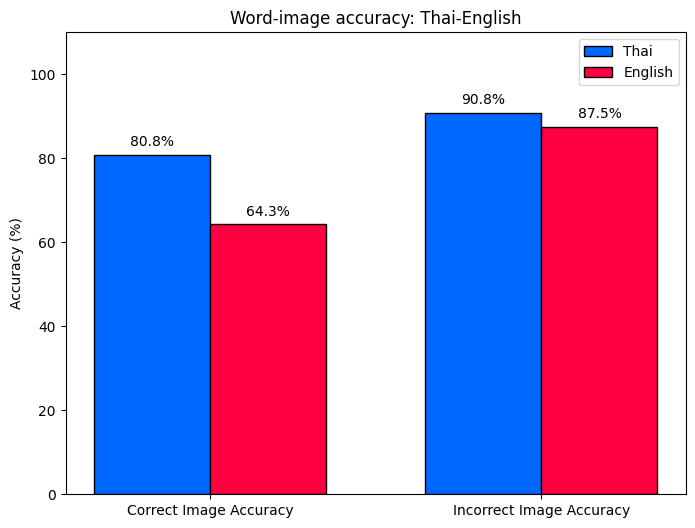

In [226]:
III_accuracy_group(imgordth, imgorden, "Word-image accuracy: Thai-English",f"./figure/{username} III image truefalse TH-EN.png")

# Reaction time part
---

## Overall reaction time in both histogram and boxplot

In [44]:
import matplotlib.font_manager as fm
thai_font_path="./THSarabun.ttf"
def III_plot_RT_outliers(inidf, lang,  title="Reaction Time Choosing Image Appear", save_path=None):


    df = inidf[inidf['score'] == 1]
    if 'key_RT' not in df or 'word shown' not in df:
        raise ValueError("The DataFrame must contain 'key_RT' and 'word shown' columns.")

    # Calculate outlier thresholds using IQR method
    Q1 = df['key_RT'].quantile(0.25)
    Q3 = df['key_RT'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers = df[(df['key_RT'] < lower_bound) | (df['key_RT'] > upper_bound)]
    outliers.sort_values(by=['key_RT'], inplace = True)

    num_bins = 16

    # Create the plot
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 3]})

    # Boxplot (Top)
    sns.boxplot(data=df, x='key_RT', ax=axes[0], color='lightgray')
    axes[0].set_title(title)
    axes[0].set_xlabel('')
    axes[0].set_xlim(0,15)
    # Annotate outliers with the corresponding 'word shown' using the Thai font if provided
    prop = fm.FontProperties(fname=thai_font_path)
    i = 0
    for outlier_value, word in zip(outliers['key_RT'], outliers['word shown']):
        yax = 0 + 0.25 * ((-1) ** i)
        axes[0].text(outlier_value, yax, word, fontsize=10, ha='center', va = 'center',color='black', fontweight='light', rotation=90, fontproperties=prop)
        i = i + 1
# 
    # axes[0].set_yticks([])  # Hide y-axis ticks
    # axes[0].set_xlabel("")  # Remove x-axis label

    # Histogram (Bottom)
    colorchoice = bluegradient[4] if lang == 'th' else redgradient[4] if lang == 'en' else gaygradient[4] 
    axes[1].hist(df['key_RT'], bins=num_bins,range = (0,16) ,color=colorchoice, alpha=0.7, edgecolor='black')
    axes[1].set_title('')
    axes[1].set_xlabel("Reaction Time (s)")
    axes[1].set_ylabel("Frequency")
    axes[1].set_xticks(np.arange(0,16,1))
    axes[1].set_xlim(0,15)
    axes[1].set_ylim(0,65)

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Plot saved to {save_path}")

    plt.close()  # Prevent displaying the plot



In [45]:


III_plot_RT_outliers(imgorden, 'en', "boxplot and histogram of reaction time english word", f"./figure/{username} III RT hist english.png" )
III_plot_RT_outliers(imgordth,'th' ,"boxplot and histogram of reaction time: thai word", f"./figure/{username} III RT hist thai.png")
III_plot_RT_outliers(imgordall, 'all',"boxplot and histogram of reaction time: all word", f"./figure/{username} III RT hist all.png")


C:\Users\PH\AppData\Local\Temp\ipykernel_16544\1657169442.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers.sort_values(by=['key_RT'], inplace = True)


Plot saved to ./figure/YP III RT hist english.png


C:\Users\PH\AppData\Local\Temp\ipykernel_16544\1657169442.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers.sort_values(by=['key_RT'], inplace = True)


Plot saved to ./figure/YP III RT hist thai.png


C:\Users\PH\AppData\Local\Temp\ipykernel_16544\1657169442.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers.sort_values(by=['key_RT'], inplace = True)


Plot saved to ./figure/YP III RT hist all.png


# Reaction time by word image match state
plot a bar chart between reaction time (s) mean by the truestate of the task

In [63]:
def III_plot_RTgroup_by_state(df1, df2, title, save_dir):
  # Add a 'source' column to each dataframe to differentiate the datasets
    df1['source'], df2['source'] = 'Dataset 1', 'Dataset 2'
    combined_df = pd.concat([df1, df2])

    # Calculate means and errors by grouping by 'truestate' and 'source'
    means = combined_df.groupby(['source', 'truestate'])['key_RT'].mean().unstack()
    errors = combined_df.groupby(['source', 'truestate'])['key_RT'].sem().unstack()

    # Create a new dataframe to hold means for both datasets (Dataset 1, Dataset 2)
    penguin_means = {
        'Dataset 1': means.loc['Dataset 1'],  # Means from df1 for each truestate
        'Dataset 2': means.loc['Dataset 2'],  # Means from df2 for each truestate
    }

    # Set the x-axis and width for bar positioning
    x = np.arange(len(penguin_means['Dataset 1']))  # Locations for truestate 0 and 1
    width = 0.35  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(figsize=(6, 6))  # Specify figure size

    # Plot bars for each dataset (Dataset 1 and Dataset 2)
    for dataset, measurement in penguin_means.items():
        colorchoice = bluegradient[4] if multiplier == 0 else redgradient[4] 
        offset = width * multiplier  # Offset bars to create grouped effect
        rects = ax.bar(x + offset, round(measurement,2), width, label=dataset, yerr=errors.loc[dataset], color = colorchoice, capsize=5, edgecolor = "black")
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add labels, title, and customize the x-axis ticks
    ax.set_ylabel('Reaction Time (s)')
    ax.set_title(title)
    ax.set_xticks(x + width / 2, ['Image word mismatched', 'Image word matched'])
    ax.legend(
      labels=['Thai', 'English'],  # Custom labels
      title='Language',            # Customize the title of the legend
      loc='upper center',               # Location of the legend
      fontsize=12,                      # Font size for legend labels
      ncol=2,                           # Number of columns for the legend
      bbox_to_anchor=(0.5, 1)       # Position the legend below the plot
    )

    # Customize y-axis limits if needed
    ax.set_ylim(0, 6)

    # Save the plot to the specified directory
    plt.xlabel('match state')
    plt.savefig(save_dir)
    plt.close()


In [69]:
III_plot_RTgroup_by_state(imgordth, imgorden, "Reaction time by word image state: Thai-English", f"./figure/{username} III RT by state EN-TH.png")

# Reaction time by word image match state both language
plot a grouped bar chart between reaction time (s) mean by the truestate of the task, both thai and english next to each other

In [61]:
def III_plot_RT_with_error_bars(df, title, save_dir):

     # Calculate means and errors by grouping by 'truestate'
    means = df.groupby('truestate')['key_RT'].mean()
    errors = df.groupby('truestate')['key_RT'].sem()

    # Define labels for truestates
    labels = {0: 'word image mismatched', 1: 'word image matched'}

    # Set the figure size (adjust accordingly)
    plt.figure(figsize=(4, 6))  # Change the width and height here

    # Set bar width to scale with figure size
    bar_width = 0.4  # Adjust the bar width to fit within the plot's space

    # Bar plot with error bars
    bars = plt.bar(means.index, means, yerr=errors, capsize=5, width=bar_width, color=[colincorrect, colcorrect], edgecolor = 'black')

    # Add the mean label on top of the bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        error = errors.iloc[i]  # Get the error for this specific bar
        # Place the text slightly above the bar and its error
        plt.text(bar.get_x() + bar.get_width() / 2, height + error + 0.05, f'{height:.2f}', ha='center', va='bottom', fontsize=12)

    # Set custom x-ticks and labels
    plt.xticks(means.index, [labels[i] for i in means.index])

    # Labels and title
    plt.xlabel('match state')
    plt.ylabel('Reaction Time (s)')
    plt.title(title)
    plt.ylim(0,6)

    # Save the plot to the specified directory
    plt.tight_layout()
    plt.savefig(save_dir)
    plt.close()



In [62]:
III_plot_RT_with_error_bars(imgordall, "Reaction time by word image state: Overall", f"./figure/{username} III RT by state all.png")

# Reaction time byword length
plot a bar chart between reaction time (s) mean by the word length

In [67]:
def III_plot_rt_by_len(dataframe, titles, save_directory):
    # Calculate means and standard errors
    means = dataframe.groupby('len')['key_RT'].mean()
    stderr = dataframe.groupby('len')['key_RT'].std() / np.sqrt(dataframe.groupby('len')['key_RT'].count())
    
    # Prepare data for plotting
    word_lengths = np.arange(3, 8)  # Word length from 3 to 7
    rt_means = means[word_lengths]
    rt_stderr = stderr[word_lengths]
    
    # Create the bar plot with error bars
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(word_lengths, rt_means, yerr=rt_stderr, capsize=5, color=gaygradient, edgecolor='black', alpha=0.7, width=0.5)

    # Add data labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.35, f'{height:.2f}', 
                ha='center', va='bottom', fontsize=10, color='black')
    
    # Set plot titles and labels
    ax.set_title(titles, fontsize=14)
    ax.set_xlabel('Word Length (letters)', fontsize=12)
    ax.set_ylabel('Mean Response Time (seconds)', fontsize=12)
    ax.set_xticks(word_lengths)
    ax.set_xticklabels(word_lengths)
    ax.set_ylim(0,5.5)
    
    # Save the plot
    save_path = save_directory
    plt.savefig(save_path)
    plt.close()
    print(f"Plot saved at: {save_path}")

In [68]:
III_plot_rt_by_len(imgordall, "Reaction time by word length: overall", f"./figure/{username} III RT by len all.png") 

Plot saved at: ./figure/YP III RT by len all.png


# Reaction time by word length, both language
plot a bar chart between reaction time (s) mean by the truestate of the task

In [235]:
def III_plot_rt_by_len_group(df1, df2, title, save_dir):
    # Calculate means and standard errors for both dataframes
    means1 = df1.groupby('len')['key_RT'].mean()
    stderr1 = df1.groupby('len')['key_RT'].sem()

    means2 = df2.groupby('len')['key_RT'].mean()
    stderr2 = df2.groupby('len')['key_RT'].sem()

    # Word lengths from 3 to 7
    word_lengths = np.arange(3, 8)
    
    # Prepare means and errors for both dataframes
    rt_means1 = means1[word_lengths]
    rt_stderr1 = stderr1[word_lengths]
    
    rt_means2 = means2[word_lengths]
    rt_stderr2 = stderr2[word_lengths]
    
    # Set the figure size and bar width
    plt.figure(figsize=(10, 6))  # Adjust the width and height here
    bar_width = 0.35  # Bar width to scale with the figure size

    # Create grouped bar plot with error bars
    bars1 = plt.bar(word_lengths - bar_width / 2, rt_means1, yerr=rt_stderr1, capsize=5, width=bar_width, color=bluegradient, label='Thai', edgecolor = 'black')
    bars2 = plt.bar(word_lengths + bar_width / 2, rt_means2, yerr=rt_stderr2, capsize=5, width=bar_width, color=redgradient, label='English', edgecolor = 'black')

    # Add the mean label on top of the bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        error = rt_stderr1.iloc[i]  # Get the error for this specific bar
        plt.text(bar.get_x() + bar.get_width() / 2, height + error + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=10, color='black')
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        error = rt_stderr2.iloc[i]  # Get the error for this specific bar
        plt.text(bar.get_x() + bar.get_width() / 2, height + error + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=10, color='black')

    # Labels and title
    plt.xlabel('Word Length (letters)')
    plt.ylabel('Mean Response Time (seconds)')
    plt.title(title)
    plt.xticks(word_lengths)
    plt.legend(title = "Language")

    # Save the plot to the specified directory
    plt.tight_layout()
    plt.savefig(save_dir)
    plt.close()

In [236]:
III_plot_rt_by_len_group(imgordth, imgorden, "Reaction time by word length: Thai and English", f"./figure/{username} III RT by len EN-TH.png")